In [1]:
import psycopg2 as pg
import pandas.io.sql as psql
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from nltk.corpus import wordnet as wn

In [2]:
def freebase_graph(words, connection):
     
    """
    Construct a semantic graph and labels for a set of object categories using 
    WordNet and NetworkX. 

    Parameters: 
    ----------
     words : set
         Set of words for all the categories. 

     Returns: 
     -------
     graph : graph
         Graph object containing edges and nodes for the network. 
     labels : dict
         Dictionary of all synset labels. 
     """
     
    graph = nx.DiGraph()
    labels = {}
    seen = set()

    count = 0
    def recurse(s):

        """ Recursively move up semantic hierarchy and add nodes / edges """  
            
        if not s in seen:                               # if not seen...
            seen.add(s)                                 # add to seen
            graph.add_node(s)                           # add node
            labels[s] = s                               # add label
            print(f'Entity: {s}')
            
            cursor = connection.cursor()
            query = """ select o_name 
                        from fact_train
                        where s_name = %s
                    """
            
            cursor.execute(query, (s,))
            print("Selecting rows from fact table using cursor.fetchall")
            facts = cursor.fetchall() 
            
            for fact in facts:
                fact, = fact
                labels[fact] = fact 
                graph.add_node(fact)                   # add node
                graph.add_edge(s, fact) 

    # build network containing all categories          
    for word in words:                                  # for all categories
        s = word         # create synset            
        recurse(s)                                      # call recurse

    # return the graph and labels    
    return graph, labels

In [3]:
# get connected to the database
connection = pg.connect(user='scientist',
                        password='********',
                        host='127.0.01',
                        port='5432',
                        database='tensor_factorisation_fb15k_237')

In [9]:
entity = psql.read_sql("SELECT * FROM entity WHERE name = 'Judy Garland'", connection)
entity.head()

,synset_id,name
0,/m/0g10g,Judy Garland


In [10]:
entity_sample = entity.sample(n=1)['name']
entity_sample

0    Judy Garland
Name: name, dtype: object

In [11]:
categories = set()
for sample in entity_sample:
    name = sample
    print(name)
    categories.add(name)

Judy Garland


In [12]:
# create the graph and labels
graph, labels = freebase_graph(categories, connection)
 
print(f'labels: {labels}')

Entity: Judy Garland
Selecting rows from fact table using cursor.fetchall
labels: {'Judy Garland': 'Judy Garland', 'Dirk Bogarde': 'Dirk Bogarde', 'Pin-up girl': 'Pin-up girl', 'Chelsea, London': 'Chelsea, London', 'Vincente Minnelli': 'Vincente Minnelli', 'English language': 'English language', 'Actor': 'Actor', 'The Wizard of Oz (1939 film)': 'The Wizard of Oz (1939 film)', 'Female': 'Female', 'Gene Kelly': 'Gene Kelly', 'Marriage': 'Marriage', 'Golden Globe Cecil B. DeMille Award': 'Golden Globe Cecil B. DeMille Award', 'United States': 'United States', 'A Star Is Born (1954 film)': 'A Star Is Born (1954 film)', 'Primetime Emmy Award for Individual Performance in a Variety or Music Program': 'Primetime Emmy Award for Individual Performance in a Variety or Music Program', 'Academy Award for Best Actress': 'Academy Award for Best Actress', 'Academy Award for Best Supporting Actress': 'Academy Award for Best Supporting Actress', 'Judgment at Nuremberg': 'Judgment at Nuremberg', 'Anglic

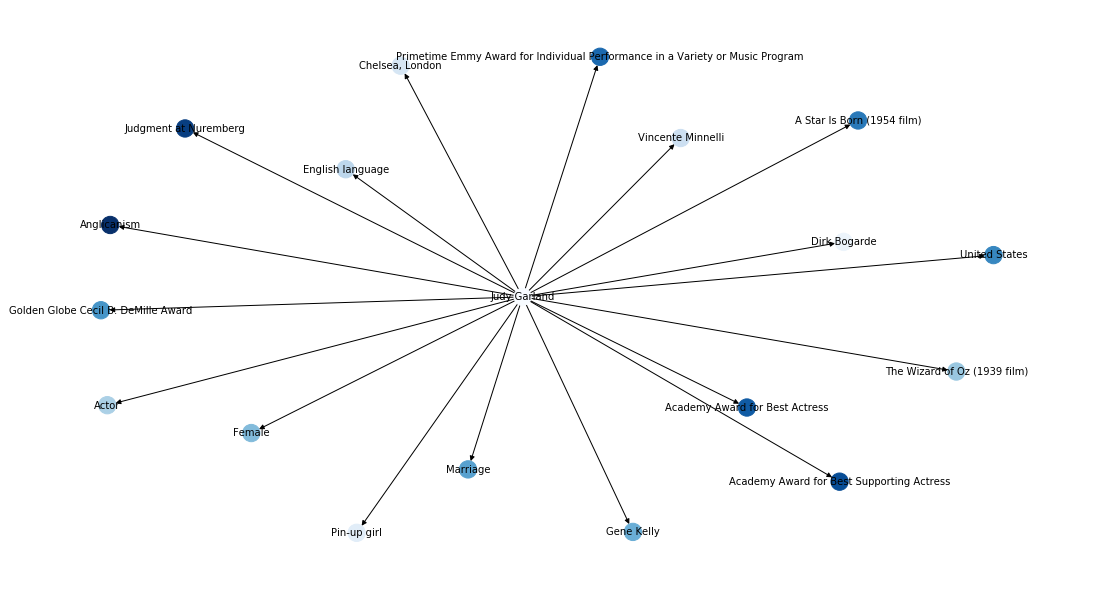

In [13]:
plt.figure(figsize=(15, 8))
# draw the graph
pos=graphviz_layout(graph)
nx.draw(graph, 
        pos=graphviz_layout(graph), 
        labels=labels,
        font_size=10,
        cmap=plt.cm.Blues,
        node_color=range(len(graph)),
        prog='dot')
plt.savefig('FB15k-237_Graph.png', format='PNG')
plt.show()